*Copyright Oak Ridge National Laboratory, 2023. All rights reserved.*

# TraKit \ TA-1 Metric `v1.0.0` Illustrative Example  


0. Setup the following before running this Jupyter Notebook
1. Imports & Variables
2. Preprocessing
    1. Stop Locations Level-1 (Stop Points)
    2. Stop Locations level-2 (Unique Stop Points)
    3. Stop Locations level-3 (Set Unique Stop Points)
    4. Timed Trips Linking Locations (TTLL) 
    5. ~~*Stop Locations level-3b (Set Unique Stop Points v.b)*~~
        1. Not provided this iteration.
    6. Set Timed Trips Linking Locations (STTLL)
3. Metrics: Movement
    1. M1 – Total Distance per Day
    2. M2 – Radius of Gyration
    3. M3 – Number of Locations Visited
    4. M4 – Temporal Variability
    5. M5 – Level of Exploration
    6. M6, M7, M8 – Speed and Acceleration Metrics
    7. M9 – Travel Time Information
    8. M10, M11 – Pairwise Encounter Frequency and Inter-encounter Time
4. Metrics: Location
    1. M12 – O-D Probability
    2. M13 – Importance
    3. M14 – Connectivity




-----------------------------------
-----------------------------------
-----------------------------------

## 0. Setup the following before running this Jupyter Notebook  

1. Go to directory named `trakit`
2. Run the following command: `conda env create -f environment.yml`
3. This will create a conda environment named `py310_trakit`
4. Then activate the conda environment before running this notebook: `conda activate py310_trakit`

-----------------------------------
-----------------------------------
-----------------------------------

## 1. Imports & Variables

### Set data source

In [2]:
data_source = "train"
data_source

'train'

In [3]:
%load_ext watermark
%watermark

Last updated: 2023-07-24T08:20:56.685847-04:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.0-76-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit



### Import necessary libraries 

In [4]:
import datetime
import glob
import itertools
import os
import time
import pyspark

import folium
import networkx
import numpy
import pandas
import matplotlib.pyplot as plt
import geopandas

import sys
sys.path.append("../../")
import trakit

pandas.set_option("display.max_colwidth", None)

%watermark -w
%watermark -iv

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Watermark: 2.4.3

geopandas : 0.13.2
networkx  : 3.1
folium    : 0.14.0
sys       : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
numpy     : 1.25.0
pandas    : 2.0.3
trakit    : <function version at 0x7ff5ee05d090>
matplotlib: 3.7.1
pyspark   : 3.2.1



### Directory & Filepath variables
#### Directories

In [5]:
data_dir = os.path.join(".", "data")

##### Input directories

In [6]:
input_dir = os.path.join(data_dir, "input")
print(f"input_dir: {input_dir}")
#  - User/Agent/Actor directories
actor_dir = os.path.join(input_dir, data_source)
print(f"actor_dir {actor_dir}")
# - auxiliary
aux_dir = os.path.join(input_dir, "auxiliary")
print(f"aux_dir: {aux_dir}")
# - reference
ref_dir = os.path.join(input_dir, "reference")
print(f"ref_dir: {ref_dir}")

input_dir: ./data/input
actor_dir ./data/input/train
aux_dir: ./data/input/auxiliary
ref_dir: ./data/input/reference


##### Output directories

In [7]:
output_dir = os.path.join(data_dir, "output", data_source)
print(f"output_dir: {output_dir}")
#  - preprocessed directories
prep_dir = os.path.join(output_dir, "preprocess")
print(f"prep_dir: {prep_dir}")
#  - intermedate directories
inter_metric_dir = os.path.join(output_dir, "metric_intermediate")
print(f"inter_metric_dir: {inter_metric_dir}")
#  - aggregate directories
agg_metric_dir = os.path.join(output_dir, "metric_aggregate")
print(f"agg_metric_dir: {agg_metric_dir}")

output_dir: ./data/output/train
prep_dir: ./data/output/train/preprocess
inter_metric_dir: ./data/output/train/metric_intermediate
agg_metric_dir: ./data/output/train/metric_aggregate


#### File base names

##### Input

In [8]:
#hex_base = "knox_hex_{}.geojson"
hex_base = "aoi.geojson"
hex_base

'aoi.geojson'

##### Output
*Preprocessed files*

In [9]:
# Stop Locations Level-1 (Stop Points)
prep_sl_l1_sp_base = "sl_l1_sp"

# Stop Locations Level-2 (Unique Stop Points)
prep_sl_l2_usp_base = "sl_l2_usp"

# Stop Locations Level-3 (Set Unique Stop Points)
prep_sl_l3_susp_base = "sl_l3_susp"

# Timed Trips Linking Locations (TTLL)
prep_ttll_base = "ttll_thres_{}"

# Stop Locations Level-3b (Set Unique Stop Points v.b)
#prep_sl_l3b_susp_base = "sl_l3b_susp" # <---------------- Not provided this iteration.

# Set Timed Trips Linking Locations (STTLL)
prep_sttll_base = "s" + prep_ttll_base

*Metric (Intermediate, Aggregrate) and Scorecard*

In [10]:
metric_output_base = "m{}_{}"

-----------------------------------
-----------------------------------
-----------------------------------

## 2. Preprocessing

### 2.A. Stop Locations Level-1 (Stop Points)
Function call:
* `trakit.stop_point.extract_stop_points( )`

##### Reading raw trajectory data from parquet files in this example 

In [11]:
#actor_files = glob.glob(os.path.join(actor_dir, "*.csv"))
actor_files = glob.glob(os.path.join(actor_dir, "*.parquet"))
actor_files += glob.glob(actor_dir + "/*/*.parquet")
actor_files

['./data/input/train/agent=4787/part-00000-ea0e6a1d-e588-4733-b720-479a0e24e136.c000.zstd.parquet',
 './data/input/train/agent=2177/part-00000-5035cf20-3397-43ce-a5c2-5c2defab1b10.c000.zstd.parquet',
 './data/input/train/agent=6887/part-00000-c6069d2f-4739-4fd3-99f5-2c3ff42d7605.c000.zstd.parquet',
 './data/input/train/agent=1578/part-00000-7866b8a8-66c6-4f4f-bc24-95324c839cbc.c000.zstd.parquet',
 './data/input/train/agent=8400/part-00000-660bbaa5-0eee-4695-a35b-33aa38f6cc5d.c000.zstd.parquet',
 './data/input/train/agent=7173/part-00000-7e499ebc-8d63-462f-b6b3-16f8e441aece.c000.zstd.parquet',
 './data/input/train/agent=8802/part-00000-44b2a09c-049b-436b-b344-0feb606eebeb.c000.zstd.parquet',
 './data/input/train/agent=71/part-00000-079e8a90-23f0-45e2-85fd-4499c8ec8016.c000.zstd.parquet',
 './data/input/train/agent=1765/part-00000-c2417fa0-da82-4ae3-aa3f-29aed3968aa2.c000.zstd.parquet',
 './data/input/train/agent=5533/part-00000-d7f7a308-7b37-42a3-8036-a9e250d9ebf5.c000.zstd.parquet',
 '

In [12]:
n_actors = len(actor_files)
n_actors

10000

##### Store the Stops Points and a dataframe of them once processed for later use

In [13]:
sp_processed = {}
sp_dfs_processed = {}

In [14]:
_actor_files = actor_files
_out_path = prep_dir
_out_file_base = prep_sl_l1_sp_base
_out_file_base

'sl_l1_sp'

In [16]:
# save list of agent uids
uids = []
for af in _actor_files:
    uids.append(af.split(os.sep)[-2])

actor_pd = pandas.DataFrame(sorted(uids))


actor_pd.to_csv(_out_path + "/agent_uids.csv", header=False)


In [19]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool

def get_stop_points(params):
    '''
    This function is meant to be called in parallel (Pool)
    '''
    filename = params

    # get the uid from the filename
    #uid = filename.split(os.sep)[-1].split(".")[0]
    uid = filename.split(os.sep)[-2]
    #print(f"** User/Agent/Actor – {uid} **")

    user_data = pandas.read_parquet(filename)

    user_data["timestamp"] = user_data["timestamp"].map(
        lambda x: pandas.Timestamp(x).timestamp()
        )

    # Call ``trakit.stop_point.extract_stop_points()`` to calculate the
    # Stop Points (Stop Locations Level-1) for a simulation actor's trajectory data
    stops = trakit.stop_point.extract_stop_points(user_data)
    stops_frame = pandas.DataFrame.from_records(item.to_dict() for item in stops)

    # write out level-1 stop points
    outpath = os.path.join(_out_path, f"{_out_file_base}_{uid}.csv")
    stops_frame.to_csv(outpath, index=False) 

    # return the info for re-assembly
    return (uid, stops, stops_frame)


In [24]:


start_time = time.time()

# - For each Actor:
#   - Read in the trajectory data file
#   - Generate the corresponding Stop Points (Stop Locations Level-1)
"""
for inpath in _actor_files:
    
    __start_time = time.time()
    
    # isolate the user/actor ID
    uid = inpath.split(os.sep)[-1].split(".")[0]
    print(f"** User/Agent/Actor – {uid} **")
    
    if (uid in sp_processed) and (uid in sp_dfs_processed):
        print(f"\n\t--> Level 1 Stop Locations already processed <--")
        stops_frame = sp_dfs_processed[uid]
    else:
        # Reading trajectory data file
        #user_data = pandas.read_csv(inpath, index_col=0)
        user_data = pandas.read_parquet(inpath)
        print(f"\t Trajectory records: {user_data.shape[0]}")
        display(user_data.head())
        
        user_data["timestamp"] = user_data["timestamp"].map(
            lambda x: pandas.Timestamp(x).timestamp()
        )

        # Call ``trakit.stop_point.extract_stop_points()`` to calculate the
        # Stop Points (Stop Locations Level-1) for a simulation actor's trajectory data
        stops = trakit.stop_point.extract_stop_points(user_data)
        stops_frame = pandas.DataFrame.from_records(item.to_dict() for item in stops)

        # write out level-1 stop points
        outpath = os.path.join(_out_path, f"{_out_file_base}_{uid}.csv")
        stops_frame.to_csv(outpath, index=False) 

        # Store both user's Stops Points and dataframe for later use
        sp_processed[uid] = stops
        sp_dfs_processed[uid] = stops_frame
    

    print(f"\n\tStop Points calculated: {stops_frame.shape[0]}")
    display(stops_frame.head())

    __stop_time = round(time.time() - __start_time, 3)
    print(f"\n\tProcess time (sec.) for {uid}: {__stop_time}")
    print("----------------------------------------------------------------\n\n")
"""

with Pool(10) as p:
    return_data = list(tqdm(p.imap(get_stop_points, _actor_files),
                            total=len(_actor_files)))

print("===============================================================")
stop_time = round(time.time() - start_time, 3)    
print(f"Process time (sec.) for {len(_actor_files)} users (actors): {stop_time}")
print("===============================================================")

  0%|          | 0/10000 [00:00<?, ?it/s]

 83%|████████▎ | 8272/10000 [10:43:50<2:14:29,  4.67s/it]


KeyboardInterrupt: 

In [321]:
# reassemble the points from the return data
for x in return_data:
    uid, stops, stops_frame = x
    if stops == []:
        # remove these agents from the list of agents for now
        print(f"not stops for agent {uid}")
        continue
    # Store both user's Stops Points and dataframe for later use
    sp_processed[uid] = stops
    sp_dfs_processed[uid] = stops_frame

not stops for agent agent=1359
not stops for agent agent=7063
not stops for agent agent=7634
not stops for agent agent=876
not stops for agent agent=5320
not stops for agent agent=1978
not stops for agent agent=4165
not stops for agent agent=7135
not stops for agent agent=1962
not stops for agent agent=5854
not stops for agent agent=69
not stops for agent agent=6364
not stops for agent agent=8579
not stops for agent agent=4703
not stops for agent agent=1891
not stops for agent agent=4523


### Illustrating/visualizing Stop Points computed for 1 actor 

In [322]:
#actor = "0a1039e3-373d-44bd-9dfb-2138b621334c"
actor = list(sp_dfs_processed.keys())[0]
#actor = "agent=1359"
print(actor)
actor_sp_df = sp_dfs_processed[actor]
print(sp_processed[actor])
print(sp_dfs_processed[actor])

agent=4787
[<trakit.stop_point.StopPoint object at 0x7f48d00eb460>, <trakit.stop_point.StopPoint object at 0x7f48d00ea920>, <trakit.stop_point.StopPoint object at 0x7f48d00ead10>, <trakit.stop_point.StopPoint object at 0x7f48d00eae60>, <trakit.stop_point.StopPoint object at 0x7f48d00eada0>, <trakit.stop_point.StopPoint object at 0x7f48d00eaf80>, <trakit.stop_point.StopPoint object at 0x7f48d00eaef0>, <trakit.stop_point.StopPoint object at 0x7f48d00eacb0>, <trakit.stop_point.StopPoint object at 0x7f48d00eadd0>, <trakit.stop_point.StopPoint object at 0x7f48d00ead40>, <trakit.stop_point.StopPoint object at 0x7f48d00eae00>, <trakit.stop_point.StopPoint object at 0x7f48d00ea980>, <trakit.stop_point.StopPoint object at 0x7f48d00eabc0>, <trakit.stop_point.StopPoint object at 0x7f48d00eace0>, <trakit.stop_point.StopPoint object at 0x7f48d00eabf0>]
    id  latitude   longitude  start_timestamp  stop_timestamp  points
0    0  1.335307  103.745074     1.677600e+09    1.677645e+09   45059
1    1  

In [323]:
mean_lat_lon = [actor_sp_df.latitude.mean(), actor_sp_df.longitude.mean()]
stops_plot = folium.Map(location=mean_lat_lon, zoom_start=10, control_scale=True)

for _, location_info in actor_sp_df.iterrows():
    lat_lon = location_info["latitude"], location_info["longitude"]
    folium.Marker(lat_lon, popup=location_info["points"]).add_to(stops_plot)

stops_plot 

-------------------------------------------------------------

### 2.B. Stop Locations level-2 (Unique Stop Points)

Function call:
* `trakit.stop_unique.unique_stops()`

##### Reading raw trajectory data from (zipped) parquet files in this example 

In [324]:
print(help(trakit.stop_unique.unique_stops))

Help on function unique_stops in module trakit.stop_unique:

unique_stops(stop_points: collections.abc.Iterable[trakit.stop_point.StopPoint | trakit.stop_unique.UniqueStop], radius: float = 37.5) -> list[trakit.stop_unique.UniqueStop]

None


##### Store the Unique Stops Points and a dataframe of them once processed for later use

In [325]:
usp_processed = {}
usp_dfs_processed = {}

In [326]:
_out_path = prep_dir
_out_file_base = prep_sl_l2_usp_base

In [ ]:
def process_level2(uid):
    unique_stops = trakit.stop_unique.unique_stops(sp_processed[uid])
    unique_stops_frame = pandas.DataFrame.from_records(
        item.to_dict() for item in unique_stops
    )

    # write out level-2 stop points
    outpath = os.path.join(_out_path, f"{_out_file_base}_unique_{uid}.csv")
    unique_stops_frame.to_csv(outpath, index=False)

    return (uid, unique_stops, unique_stops_frame)

In [327]:
start_time = time.time()

# - For each Actor:
#   - Read in the trajectory data file
#   - Generate the corresponding Unique Stop Points (Stop Locations Level-2)
'''
for uid in sp_processed:
    __start_time = time.time()
    # print(f"** User/Agent/Actor – {uid} **")
    
    if (uid in usp_processed) and (uid in usp_dfs_processed):
        # print(f"\n\t--> Level 2 Stop Locations already processed <--")
        unique_stops_frame = usp_dfs_processed[uid]
    else:
        # 1. Call ``trakit.stop_unique.unique_stops()`` to calculate
        #    the Unique Stop Points (Stop Locations Level-2) for a simulation
        #    actor's trajectory data. 
        unique_stops = trakit.stop_unique.unique_stops(sp_processed[uid])
        unique_stops_frame = pandas.DataFrame.from_records(
            item.to_dict() for item in unique_stops
        )

        # write out level-1 stop points
        outpath = os.path.join(_out_path, f"{_out_file_base}_unique_{uid}.csv")
        unique_stops_frame.to_csv(outpath, index=False)

        # Store both user's Unique Stops Points and dataframe for later use
        usp_processed[uid] = unique_stops
        usp_dfs_processed[uid] = unique_stops_frame

    # print(f"\n\tUnique Stop Points calculated: {unique_stops_frame.shape[0]}")
    # display(unique_stops_frame.head())
    
    __stop_time = round(time.time() - __start_time, 3)
    # print(f"\n\tProcess time (sec.) for {uid}: {__stop_time}")
    # print("----------------------------------------------------------------\n\n")
'''

# make this parallel
with Pool(10) as p:
    return_data = list(tqdm(p.imap(process_level2, sp_processed.keys()),
                            total=len(sp_processed.keys())))

print("===============================================================")
stop_time = round(time.time() - start_time, 3)    
print(f"Process time (sec.) for {len(sp_processed)} users (actors): {stop_time}")
print("===============================================================")

Process time (sec.) for 9984 users (actors): 23188.781


In [ ]:
# reassemble the items into the dictionary
for x in return_data:
    uid, unique_stops, unique_stops_frame = x
    # Store both user's Unique Stops Points and dataframe for later use
    usp_processed[uid] = unique_stops
    usp_dfs_processed[uid] = unique_stops_frame

### Illustrating/visualizing Unique Stop Points computed for 1 actor 

In [328]:
#actor = "0a1039e3-373d-44bd-9dfb-2138b621334c"
actor = list(sp_dfs_processed.keys())[0]
print(actor)
actor_usp_df = usp_dfs_processed[actor]

agent=4787


In [329]:
mean_lat_lon = [
    actor_usp_df.latitude.mean(), actor_usp_df.longitude.mean()
]
unique_stops_plot = folium.Map(location=mean_lat_lon, zoom_start=10, control_scale=True)

for _, location_info in actor_usp_df.iterrows():
    lat_lon = location_info["latitude"], location_info["longitude"]
    folium.Marker(lat_lon, popup=location_info["stop_points"]).add_to(unique_stops_plot)

unique_stops_plot

-------------------------------------------------------------

### 2.C. Stop Locations level-3 (Set Unique Stop Points) 

In [330]:
_in_path = prep_dir
_in_file_base = prep_sl_l2_usp_base

_out_path = prep_dir
_out_file_base = prep_sl_l3_susp_base

In [ ]:
def process_level3(uid):
    unique_stops = usp_processed[uid]
    temp_list = list(
        trakit.stop_unique.uid_tag_id_values(uid, unique_stops)
    )

    return (uid, temp_list)


In [331]:
# Extend id values to {uid}_{stop_id}
'''
unique_stops_id_extended = dict()
for uid, unique_stops in usp_processed.items():
    unique_stops_id_extended[uid] = list(
        trakit.stop_unique.uid_tag_id_values(uid, unique_stops)
    )
'''

# run this in parallel
with Pool(10) as p:
    return_data = list(tqdm(p.imap(process_level3, usp_processed.keys()),
                            total=len(usp_processed.keys())))
# re-assemble the data into the dictionary
unique_stops_id_extended = dict()
for x in return_data:
    uid, templist = x
    unique_stops_id_extended[uid] = templist

# And extract set unique stops from extended id unique stops
set_unique_stops = trakit.stop_unique.unique_stops(
    itertools.chain(*unique_stops_id_extended.values())
)

In [1]:
set_unique_frame = pandas.DataFrame.from_records(
    item.to_dict() for item in set_unique_stops
)
set_unique_frame.to_csv(os.path.join(_out_path, f"{_out_file_base}.csv"), index=False)

NameError: name 'pandas' is not defined

### Illustrating/visualizing Set Unique Stop Points computed for all actors

In [280]:
mean_lat_lon = [
    set_unique_frame.latitude.mean(), set_unique_frame.longitude.mean()
]
set_unique_stops_plot = folium.Map(
    location=mean_lat_lon, zoom_start=10, control_scale=True
)

for _, location_info in set_unique_frame.iterrows():
    lat_lon = location_info["latitude"], location_info["longitude"]
    folium.Marker(
        lat_lon, popup=location_info["stop_points"]
    ).add_to(set_unique_stops_plot)

set_unique_stops_plot

-------------------------------------------------------------


### 2.D. Timed Trips Linking Locations (TTLL) 

Function call:
* `trakit.timed_trips_linking_locations.timed_trips_linking_locations()`

In [281]:
from trakit.timed_trips_linking_locations import timed_trips_linking_locations

print(help(timed_trips_linking_locations))

Help on function timed_trips_linking_locations in module trakit.timed_trips_linking_locations:

timed_trips_linking_locations(df: pandas.core.frame.DataFrame, udf: pandas.core.frame.DataFrame, threshold: float = 5.0, proc_kws: dict = {}, ttll_kws: dict = {}) -> pandas.core.frame.DataFrame
    Generate Timed Trips Linking Locations from raw and unique stop locations.
    
    Parameters
    ----------
    
    df : pandas.DataFrame
        All stop locations.
    udf : pandas.DataFrame
        Unique stop locations.
    threshold : int (default 5.)
        Minimum minutes for an identical from-to pair to be
        considered round trip vs. squashed record.
          * round trip – valid identical from-to pair – take dog for long walk
          * squashed record – walk to end of drive to check mail
    proc_kws : dict (default is dict())
        Keyword arguements for ``process_stops()``.
    ttll_kws : dict (default is dict())
        Keyword arguements for ``generate_ttll()``.
    
  

##### Parameters
* `threshold`
  * minutes (default 5) by which round trips (from node == to node) are merged into a single location if the trip duration is less than `threshold`.

In [33]:
threshold = 5

##### Generate from processed Stop Point and Unique Stop Point data

In [34]:
ttll_dfs = {}

In [ ]:
_out_path = prep_dir
_out_file_base = prep_ttll_base.format(threshold)

In [35]:
time_per = []
for ix, uid in enumerate(sp_dfs_processed.keys()):
    
    time_start = time.time()
    
    # Isolate the Stop Points and Unique Stop Points dataframes
    sp_df = sp_dfs_processed[uid].copy()
    usp_df = usp_dfs_processed[uid].copy()
    
    # Calculate the TTLL
    ttll_df = timed_trips_linking_locations(sp_df, usp_df, threshold=threshold)
    ttll_df.reset_index(inplace=True)
    
    # Write TTLL for file
    outpath = os.path.join(_out_path, f"{_out_file_base}_{uid}.csv")
    ttll_df.to_csv(outpath, index=False)
    
    # Record timing for performance evaluation
    time_end = time.time() - time_start
    time_per.append(round(time_end, 3))
    
    ttll_dfs[uid] = ttll_df

time_per = pandas.DataFrame(time_per)
n_users = time_per.shape[0]
total_time = round(time_per[0].sum(), 3)
print(f"{n_users} users/actors runs in {total_time} seconds.")
time_per.describe().T[["mean", "std", "min", "max"]]

2 users/actors runs in 0.073 seconds.


,mean,std,min,max
0,0.0365,0.003536,0.034,0.039


#### Demonstrating the TTLL data structure's [COO-style sparse format](https://scipy-lectures.org/advanced/scipy_sparse/coo_matrix.html) for 1 actor

* ``'from'`` - From unique ID
* ``'to'`` - To unique ID
* ``'trip_info'`` - Aggregated trip information in the following
  list format:
  *   ``[<count>, [[t0_0, t1_0], [t0_1, t1_1], ...]]]``
  * Where:
    * The first element (``<count>``) is the number of trips between ``'from'``and ``'to'``.
    * The second element ``[[t0_0, t1_0], [t0_1, t1_1], ...]]`` is a nested list of lists representing the start  (``t0_X``) and stop (``t1_X``) time for each trip comprising ``<count>``. For example, the first trip (``[t0_0, t1_0]``) is indexed as ``_0``, and starts at ``t0`` and stops at ``t1``.

In [37]:
#actor = "0a1039e3-373d-44bd-9dfb-2138b621334c"
actor = list(sp_dfs_processed.keys())[0]
print(actor)
ttll_dfs[actor]

part-00000-5551339c-daa2-46af-ad3d-05486818b52d


,from,to,trip_info
0,0,1,"[7, [(1677634621.0, 1677635391.0), (1677731778.0, 1677732513.0), (1677808105.0, 1677808806.0), (1677893679.0, 1677894402.0), (1677987099.0, 1677987803.0), (1678086105.0, 1678086817.0), (1678152886.0, 1678153706.0)]]"
1,1,0,"[6, [(1677678613.0, 1677679061.0), (1677775734.0, 1677776264.0), (1677852025.0, 1677852603.0), (1677937622.0, 1677938102.0), (1678031022.0, 1678031594.0), (1678130037.0, 1678130597.0)]]"


-------------------------------------------------------------

### 2.E. ~~Stop Locations level-3b (Set Unique Stop Points v.b)~~

In [38]:
# Not provided this iteration.

-------------------------------------------------------------

### 2.F. Set Timed Trips Linking Locations (STTLL)

Function call:
* `trakit.timed_trips_linking_locations.set_timed_trips_linking_locations()`

In [39]:
print(help(trakit.timed_trips_linking_locations.set_timed_trips_linking_locations))

Help on function set_timed_trips_linking_locations in module trakit.timed_trips_linking_locations:

set_timed_trips_linking_locations(susp_df: str | pandas.core.frame.DataFrame, ttll_data: list | pandas.core.frame.DataFrame, spnts: str = 'stop_points', generic_id: str = 'id', susp_id: str = 'susp', usp_id: str = 'usp', tinfo_col: str = 'trip_info', user_id: str = 'user_id', f: str = 'from', t: str = 'to') -> pandas.core.frame.DataFrame
    Create a set-TTLL dataframe.
    
    Parameters
    ----------
    
    susp_df : str | pandas.DataFrame
        Set Unique Stop Points data.
    ttll_data : list | pandas.DataFrame
        All user's Timed Trips Linking Locations data.
    spnts : str (default 'stop_points')
        Stop point column in ``susp_df``. These are unique stop point in the
        format <USERID>_<USPID>.
    generic_id: str (default 'id')
        Generic ID column name ``susp_df`` for Set Unique Stop Points.
    susp_id: str (default 'susp')
        Set Unique Stop Poin

##### First, stack the TTLL actor-level data

In [40]:
print(help(trakit.timed_trips_linking_locations.stack_ttll_frames))

Help on function stack_ttll_frames in module trakit.timed_trips_linking_locations:

stack_ttll_frames(ttll_data: dict, tinfo_col: str, user_id: str) -> pandas.core.frame.DataFrame
    Concatenate all TTLL user dataframes into single
    dataframe with a column denoting User ID.
    
    Parameters
    ----------
    
    ttll_data : dict
        User-level TTLL data keyed by user ID.
    tinfo_col: str (default 'trip_info')
        Trip information column name in ``ttll_data`` in the following
        format: ``[<count>, [[t0_0, t1_0], [t0_1, t1_1], ...]]]``
    user_id: str (default 'user_id')
        Column name to be used in intermediary processing ``ttll_data``.
    
    Returns
    -------
    
    ttll_data : pandas.DataFrame
        stacked Timed Trips Linking Locations.

None


In [41]:
stacked_ttll = trakit.timed_trips_linking_locations.stack_ttll_frames(
    ttll_dfs, "trip_info", "user_id"
)
stacked_ttll

,from,to,trip_info,user_id
0,0,1,"[7, [(1677634621.0, 1677635391.0), (1677731778.0, 1677732513.0), (1677808105.0, 1677808806.0), (1677893679.0, 1677894402.0), (1677987099.0, 1677987803.0), (1678086105.0, 1678086817.0), (1678152886.0, 1678153706.0)]]",part-00000-5551339c-daa2-46af-ad3d-05486818b52d
1,1,0,"[6, [(1677678613.0, 1677679061.0), (1677775734.0, 1677776264.0), (1677852025.0, 1677852603.0), (1677937622.0, 1677938102.0), (1678031022.0, 1678031594.0), (1678130037.0, 1678130597.0)]]",part-00000-5551339c-daa2-46af-ad3d-05486818b52d
2,0,1,"[6, [(1677634976.0, 1677637996.0), (1677802235.0, 1677806468.0), (1677894184.0, 1677897927.0), (1677979887.0, 1677982778.0), (1678066857.0, 1678069816.0), (1678153208.0, 1678156119.0)]]",part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d
3,0,2,"[1, [(1677714176.0, 1677716562.0)]]",part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d
4,1,0,"[6, [(1677681206.0, 1677684997.0), (1677762215.0, 1677765909.0), (1677849685.0, 1677853666.0), (1677941142.0, 1677944550.0), (1678025994.0, 1678029696.0), (1678113028.0, 1678116085.0)]]",part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d
5,2,1,"[1, [(1677717550.0, 1677719003.0)]]",part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d


##### Next, Generate the STTLL data from the SUSP and stacked TTLL

In [42]:
sttll = trakit.timed_trips_linking_locations.set_timed_trips_linking_locations(
    set_unique_frame.copy(),
    stacked_ttll.copy()
)

In [43]:
_out_path = prep_dir
_out_file_base = prep_sttll_base.format(threshold)
out_path = os.path.join(_out_path, f"{_out_file_base}.csv")
sttll.to_csv(out_path, index=False)

#### Demonstrating the STTLL data structure's [COO-style sparse format](https://scipy-lectures.org/advanced/scipy_sparse/coo_matrix.html) (all actors)

* Structure identical to TTLL above.

In [44]:
sttll

,from,to,trip_info
0,0,1,"[7, [(1677634621.0, 1677635391.0), (1677731778.0, 1677732513.0), (1677808105.0, 1677808806.0), (1677893679.0, 1677894402.0), (1677987099.0, 1677987803.0), (1678086105.0, 1678086817.0), (1678152886.0, 1678153706.0)]]"
1,1,0,"[6, [(1677678613.0, 1677679061.0), (1677775734.0, 1677776264.0), (1677852025.0, 1677852603.0), (1677937622.0, 1677938102.0), (1678031022.0, 1678031594.0), (1678130037.0, 1678130597.0)]]"
2,2,3,"[6, [(1677634976.0, 1677637996.0), (1677802235.0, 1677806468.0), (1677894184.0, 1677897927.0), (1677979887.0, 1677982778.0), (1678066857.0, 1678069816.0), (1678153208.0, 1678156119.0)]]"
3,2,4,"[1, [(1677714176.0, 1677716562.0)]]"
4,3,2,"[6, [(1677681206.0, 1677684997.0), (1677762215.0, 1677765909.0), (1677849685.0, 1677853666.0), (1677941142.0, 1677944550.0), (1678025994.0, 1678029696.0), (1678113028.0, 1678116085.0)]]"
5,4,3,"[1, [(1677717550.0, 1677719003.0)]]"


-------------------------------------------------------------
-------------------------------------------------------------
-------------------------------------------------------------



## 3. Metrics: Movement
### 3.A. M1 – Total Distance per Day

In [45]:
from trakit import distance_per_day

#### Generate and write user-level Total Distance per Day

In [46]:
metric_label = "1"
_out_path = inter_metric_dir

In [48]:
distances = []
for uid, sp in sp_dfs_processed.items():
    sp_df = sp.copy()
    sp_df = pandas.DataFrame({"uid": uid, "distance": distance_per_day(sp_df)})
    sp_df.reset_index(inplace=True)
    sp_df["datetime"] = sp_df["start_datetime"]
    sp_df = sp_df[["uid", "datetime", "distance"]].copy()
    _out_file_base = metric_output_base.format(metric_label, uid)
    out_path = os.path.join(_out_path, f"{_out_file_base}.csv")
    sp_df.to_csv(out_path, index=False)
    distances.append(sp_df)

##### Demonstrating 1 user's Total Distance per Day data

In [49]:
distances[0]

,uid,datetime,distance
0,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-01,14402.246452
1,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-02,7209.286693
2,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-03,21594.974558
3,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-04,14405.576181
4,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-05,14395.77823
5,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-06,7196.340071
6,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-07,14400.297836


#### Aggregate user-level Total Distance per Day for one combined file

In [50]:
_out_path = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")
out_path = os.path.join(_out_path, f"{_out_file_base}")
if out_path.endswith("_"):
    out_path = out_path[:-1]
out_path = f"{out_path}.csv"

In [52]:
aggregated_distances = pandas.concat(distances)
aggregated_distances.to_csv(out_path, index=False)
aggregated_distances

,uid,datetime,distance
0,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-01,14402.246452
1,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-02,7209.286693
2,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-03,21594.974558
3,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-04,14405.576181
4,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-05,14395.77823
5,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-06,7196.340071
6,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023-03-07,14400.297836
0,part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d,2023-03-01,87819.145477
1,part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d,2023-03-02,91719.268659
2,part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d,2023-03-03,87806.720075


-------------------------------------------------------------

### 3.B. M2 – Radius of Gyration

Function call:
* `trakit.radius_of_gyration()`

In [53]:
from trakit import radius_of_gyration
print(help(radius_of_gyration))

Help on function radius_of_gyration in module trakit.metrics.radius_of_gyration:

radius_of_gyration(df: pandas.core.frame.DataFrame, wcol: None | str = None, ycol: str = 'latitude', xcol: str = 'longitude', time_start: str = 'start_timestamp', time_stop: str = 'stop_timestamp', time_units: str = 'minutes', sq_dist_kws: dict = {}) -> float
    Calculate the Radius of Gyration for 1 user.
    
    .. math:
    
        \displaystyle r^u_g=\sqrt{\frac{1}{T}\sum^N_{n=1}t^u_n(r^u_n-r^u_{cm})^2}
    
    Parameters
    ----------
    
    df : pandas.DataFrame
        A single user's profile.
    wcol : str (default None)
        Weights column name. Leave as ``None`` for the unweighted RoG.
    ycol : str (default is 'latitude')
        Y / latitude of a stop point.
    xcol : str (default is 'longitude')
        X / longitude of a stop point.
    time_start : str (default is 'start_timestamp')
        Starting timestamp at stop point.
    time_stop : str (default is 'stop_timestamp')
    

##### Parameters
* `dist_units`
  * calculate the Radius of Gyration in kilometers.

In [54]:
dist_units = "km"
dist_params = dict(dist_units=dist_units)

##### Set up a storage dataframe for results and diagnostic information

In [55]:
rog_lab = f"RoG_{dist_units}"
columns = ["user_id", "n_obs", rog_lab, "runtime_sec"]
rog_df = pandas.DataFrame(columns=columns, index=range(n_actors))
rog_df

,user_id,n_obs,RoG_km,runtime_sec
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN


##### Calculate Radius of Gyration from processed Stop Point data

In [56]:
metric_label = "2"
_out_path = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")

In [57]:
global_start_time = time.time()
for ix, (uid, sp) in enumerate(sp_dfs_processed.items()):
    
    # calculate 1 user's Radius of Gyration
    user_time_start = time.time()
    sp_df = sp.copy()
    rog = radius_of_gyration(sp_df, sq_dist_kws=dist_params)
    user_time_end = round(time.time() - user_time_start, 2)
    
    # store output
    rog_df.loc[ix] = [uid, sp_df.shape[0], rog, user_time_end]

# ensure numeric dtype
rog_df = trakit.utils.coerce_numeric(rog_df, *["n_obs", rog_lab, "runtime_sec"])

# write results
outpath = os.path.join(_out_path, f"{_out_file_base}")
if outpath.endswith("_"):
    outpath = outpath[:-1]
outpath = f"{outpath}.csv"
rog_df.to_csv(outpath, index=False)

global_time_end = round(time.time() - global_start_time, 2)
print(f"Total Runtime (seconds): {global_time_end}")
rog_df

Total Runtime (seconds): 0.03


,user_id,n_obs,RoG_km,runtime_sec
0,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,14,3.599934,0.01
1,part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d,15,21.633633,0.01


##### Descriptive statistics of solutions

In [58]:
rog_df[["n_obs", "RoG_km", "runtime_sec"]].describe()

,n_obs,RoG_km,runtime_sec
count,2.000000,2.000000,2.00
mean,14.500000,12.616784,0.01
std,0.707107,12.751751,0.00
min,14.000000,3.599934,0.01
25%,14.250000,8.108359,0.01
50%,14.500000,12.616784,0.01
75%,14.750000,17.125208,0.01
max,15.000000,21.633633,0.01


-------------------------------------------------------------

### 3.C. M3 – Number of Locations Visited


In [59]:
stops_formatter = os.path.join(
    prep_dir, "{}_{}.csv".format(prep_sl_l1_sp_base, "{}")
)
unique_stops_formatter = os.path.join(
    prep_dir, "{}_{}.csv".format(prep_sl_l2_usp_base, "{}")
)

print(help(trakit.locations_frequency.stop_points_reduce))
print(help(trakit.locations_frequency.locations_per_day))

Help on function stop_points_reduce in module trakit.metrics.locations_frequency:

stop_points_reduce(stops: list[trakit.stop_point.StopPoint], unique_stops: list[trakit.stop_unique.UniqueStop], drop_weekends: bool = True) -> list[tuple[datetime.date, int]]
    Using stop points, pairs occurrences of unique stops to dates
    
    Parameters
    ----------
    stops: list of StopPoint objects of a given actor
    unique_stops: list of UniqueStop objects of a given actor
    drop_weekends: bool for whether weekends should be ignored
    
    Returns
    -------
    list of (datetime.date, unique stop id int) items

None
Help on function locations_per_day in module trakit.metrics.locations_frequency:

locations_per_day(date_locs: list[tuple[datetime.date, int]]) -> list[tuple[str, int]]
    Sums unique locations per day given date, unique id pairs
    
    Parameters
    ----------
    date_locs: list of date, unique id int pairs
    
    Returns
    -------
    list of (date, locations 

In [60]:
uid_list = [
    os.path.basename(filename)[len(prep_sl_l1_sp_base)+1:-4]
    for filename
    in glob.glob(os.path.join(prep_dir, f"{prep_sl_l1_sp_base}_*.csv"))
]

locations_per_day_frames = list()

start_time = time.perf_counter()
for uid in uid_list:
    _stops = trakit.stop_point.stop_points_from_file(stops_formatter.format(uid))
    _unique_stops = trakit.stop_unique.unique_stop_points_from_file(
        unique_stops_formatter.format(uid)
    )
    uniques_with_day = trakit.locations_frequency.stop_points_reduce(
        _stops, _unique_stops, drop_weekends=False
    )
    locations_by_day = trakit.locations_frequency.locations_per_day(uniques_with_day)
    _dates, _locations = zip(*locations_by_day)
    locations_per_day_frames.append(
        pandas.DataFrame({"uid": uid, "dates": _dates, "locations": _locations})
    )

locations_per_day_df = pandas.concat(locations_per_day_frames)
locations_per_day_df.head()

,uid,dates,locations
0,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023_03_01,2
1,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023_03_02,1
2,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023_03_03,2
3,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023_03_04,2
4,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,2023_03_05,2


In [61]:
# set up output path
metric_label = "3"
_out_path = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")
out_path = os.path.join(_out_path, _out_file_base)
if out_path.endswith("_"):
    out_path = out_path[:-1]
out_path = f"{out_path}.csv"

locations_per_day_df.to_csv(out_path, index=False)

-------------------------------------------------------------

### 3.D. M4 – Temporal Variability
Function call:
* `trakit.temporal_variability()`

In [62]:
from trakit import temporal_variability

In [63]:
print(help(temporal_variability))

Help on function temporal_variability in module trakit.metrics.temporal_variability:

temporal_variability(sdf: pandas.core.frame.DataFrame, udf: pandas.core.frame.DataFrame, n_ranks: int = 2, omit_weekend: bool = True, tz_col: str = 'tz', wkday_moment: str = 'start_timestamp', print_user_warning: bool = True) -> dict
    Calculate the standard deviation of start/stop
    time for 1 user at :math:`n` ranks.
    
    ..math:
    
       \displaystyle \sigma_{R_n^u} =
           \sqrt{\frac{1}{N_{R_n^u}}\sum^N_{n=1}(t_n^u - \mu_{R_n^u})^2}
    
    * Where
      * $\sigma_{R_n^u}$ is the standard deviation for an arrival (or departure) time at stop location of $R_n^u$
      * $R_n^u$ is the rank of stop location $n$ for user $u$
      * $n$ is an indexed stop point in the complete set of stop points $(n \in N)$
      * $u$ is a single user ID in the universe of users $U$ $(u \in U)$
      * $t_n^u$ is the timestamp of arrival time $n$ for user $u$
      * $\mu_{R_n^u}$ is the average arr

##### Parameters:
* `n_ranks`
  * the top $n$ ranks to consider
* `omit_weekend`
  * remove Saturday and Sunday from the input
* `drop_na`
  * drop `NULL` values (where there is no standard deviation due to 1 value in rank group

In [64]:
n_ranks = 2
omit_weekend = True
drop_na = True

##### Calculate Temporal Variability from processed Stop Point and Unique Stop Point data

In [65]:
metric_label = "4"
_out_path_1 = inter_metric_dir
_out_path_2 = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")

In [66]:
global_start_time = time.time()
for ix, (uid, sp) in enumerate(sp_dfs_processed.items()):
    
    # calculate 1 user's Temporal Variability
    user_time_start = time.time()
    sp_df = sp.copy()
    usp_df = usp_dfs_processed[uid].copy()
    user_tv = temporal_variability(
        sp_df,
        usp_df,
        n_ranks=n_ranks,
        omit_weekend=omit_weekend,
        print_user_warning=uid,
    )
    user_time_end = round(time.time() - user_time_start, 2)
    user_tv.update({"user_id": [uid], "runtime_sec": [user_time_end]})
    
    # store output
    if not ix:
        tv_df = pandas.DataFrame(user_tv)
    else:
        tv_df = pandas.concat([tv_df, pandas.DataFrame(user_tv)], ignore_index=True)

global_time_end = round(time.time() - global_start_time, 2)
print(f"Total Runtime (seconds): {global_time_end}")

Total Runtime (seconds): 0.05


##### User-level results

In [67]:
# Save intermediate data
outpath_1 = os.path.join(_out_path_1, f"{_out_file_base}")
if outpath_1.endswith("_"):
    outpath_1 = outpath_1[:-1]
outpath_1 = f"{outpath_1}.csv"
tv_df.to_csv(outpath_1, index=False)
tv_df

,r1-start-std,r1-stop-std,r2-start-std,r2-stop-std,user_id,runtime_sec
0,133.735934,79.700690,145.348891,145.173000,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,0.03
1,48.173644,602.030564,43.410828,43.410828,part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d,0.02


##### Aggregate results

In [68]:
std_values = tv_df.drop(columns=["user_id", "runtime_sec"]).copy().values.flatten()
if drop_na:
    std_values = std_values[~numpy.isnan(std_values)]
std_values

array([133.73593384,  79.70069008, 145.3488906 , 145.17300024,
        48.17364425, 602.03056401,  43.41082814,  43.41082814])

In [69]:
# Save aggregate data
outpath_2 = os.path.join(_out_path_2, f"{_out_file_base}")
if outpath_2.endswith("_"):
    outpath_2 = outpath_2[:-1]
outpath_2 = f"{outpath_2}.csv"
std_df = pandas.DataFrame(std_values, columns=["std"])
std_df.to_csv(outpath_2, index=False)

-------------------------------------------------------------

### 3.E. M5 – Level of Exploration


In [70]:
metric_label = "5"
_out_path = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")

In [71]:
from trakit.metrics import exploration
dfs = []
for ix, uid in enumerate(usp_dfs_processed.keys()):
    sp_df = usp_dfs_processed[uid].copy()
    dfs.append(exploration.calculate_level_of_exploration(sp_df, uid))
df = pandas.concat(dfs)
ex = exploration.calculate_freq_pct(df)

rf = ex.head(100)
outpath = os.path.join(_out_path, f"{_out_file_base}")
if outpath.endswith("_"):
    outpath = outpath[:-1]
outpath = f"{outpath}.csv"
rf.to_csv(outpath)

In [72]:
rf

,frequency,frequency_pct
Rank,,
1,14,48.275862
2,14,48.275862
3,1,3.448276


-------------------------------------------------------------

### 3.F. M6, M7, M8 – Speed and Acceleration Metrics


In [73]:
from trakit.metrics import kinematics
print(help(kinematics.calculate_kinematics))

Help on function calculate_kinematics in module trakit.metrics.kinematics:

calculate_kinematics(actor_frame: pandas.core.frame.DataFrame, time_delta_limit: int = 300, time_deltas: pandas.core.series.Series = None, valid_times: pandas.core.series.Series = None) -> tuple[pandas.core.series.Series, pandas.core.series.Series]

None


In [75]:
# M6 speed and M8 acceleration are calculated in the same step with calculate_kinematics
# M7 is calculated using the speed output to count violations

metric_start = time.perf_counter()
speed_by_uid = dict()
acceleration_by_uid = dict()

for inpath in _actor_files:
    user_start = time.perf_counter()
    uid = os.path.basename(inpath).rsplit(".")[0]
    print(f"** User/Agent/Actor - {uid} **")
    
    #user_data = pandas.read_csv(inpath, index_col=0)
    user_data = pandas.read_parquet(inpath)
    user_data["timestamp"] = user_data["timestamp"].map(
        lambda x: pandas.Timestamp(x).timestamp()
    )
    
    speed, acceleration = kinematics.calculate_kinematics(user_data)
    
    # averages
    speed_avg = speed.mean()
    acceleration_avg = acceleration.mean()
    
    # bin edges
    speed_edges = list(range(0, 101, 5))
    acceleration_edges = list(range(-10, 11, 1))
    
    # aggregate histograms
    speed_hist = kinematics.speed_histogram(speed, speed_edges)
    acceleration_hist = kinematics.acceleration_histogram(
        acceleration, acceleration_edges
    )
    
    # outliers: convenient function for speed, inference for acceleration
    speed_outliers = kinematics.calculate_speed_violations(speed)
    acceleration_outliers = acceleration.shape[0] - acceleration_hist.sum()
    
    # speed and acceleration to df for caching and later export
    # --> for ``'speed_agg'`` align lists with a fill NaN
    speed_df = pandas.DataFrame({
        "uuid": uid,
        "average": speed_avg,
        "speed_edges": speed_edges,
        "speed_agg": itertools.chain([numpy.NaN], speed_hist),
        "outliers": speed_outliers
    })
    # --> for ``'acceleration_agg'`` align lists with a fill NaN
    acceleration_df = pandas.DataFrame({
        "uuid": uid,
        "average": acceleration_avg,
        "acceleration_edges": acceleration_edges,
        "acceleration_agg": itertools.chain([numpy.NaN], acceleration_hist),
        "outliers": acceleration_outliers
    })
    display(speed_df.head())
    print(f"{uid} process time: {time.perf_counter()-user_start}")
    
    # cache values
    speed_by_uid[uid] = speed_df
    acceleration_by_uid[uid] = acceleration_df

print(f"metric process time: {time.perf_counter()-metric_start}")

** User/Agent/Actor - part-00000-5551339c-daa2-46af-ad3d-05486818b52d **


,uuid,average,speed_edges,speed_agg,outliers
0,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,0.193024,0,NaN,0
1,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,0.193024,5,597072.0,0
2,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,0.193024,10,1206.0,0
3,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,0.193024,15,3786.0,0
4,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,0.193024,20,981.0,0


part-00000-5551339c-daa2-46af-ad3d-05486818b52d process time: 23.78736891702283
** User/Agent/Actor - part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d **


,uuid,average,speed_edges,speed_agg,outliers
0,part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d,1.391714,0,NaN,0
1,part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d,1.391714,5,561713.0,0
2,part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d,1.391714,10,1243.0,0
3,part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d,1.391714,15,6962.0,0
4,part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d,1.391714,20,14423.0,0


part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d process time: 23.55205116898287
metric process time: 47.34025403589476


In [77]:
# save the three metrics
# while M7 will exist within the output of M6,
#    M7 will also be output as a duplicate of M6 for file consistency
# output speed first

# set up output path
metric_label = "6"
_out_path = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")
out_path = os.path.join(_out_path, _out_file_base)
if out_path.endswith("_"):
    out_path = out_path[:-1]
out_path = f"{out_path}.csv"

# stack all the speed dataframes and output them
speed_df_stack = pandas.concat(list(speed_by_uid.values()), ignore_index=True)
speed_df_stack.to_csv(out_path, index=False)

# speed again but for M7
# set up output path
metric_label = "7"
_out_path = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")
out_path = os.path.join(_out_path, _out_file_base)
if out_path.endswith("_"):
    out_path = out_path[:-1]
out_path = f"{out_path}.csv"

# stack all the speed dataframes and output them
speed_df_stack = pandas.concat(list(speed_by_uid.values()), ignore_index=True)
speed_df_stack.to_csv(out_path, index=False)

# and then output acceleration
metric_label = "8"
_out_path = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")
out_path = os.path.join(_out_path, _out_file_base)
if out_path.endswith("_"):
    out_path = out_path[:-1]
out_path = f"{out_path}.csv"

# stack all the acceleration dataframes and output them
acceleration_df_stack = pandas.concat(
    list(acceleration_by_uid.values()), ignore_index=True
)
acceleration_df_stack.to_csv(out_path, index=False)

-------------------------------------------------------------

### 3.G. M9 – Travel Time Information



In [78]:
from trakit import calculate_travel_time

#### Generate user-level Travel Time

In [79]:
metric_label = "9"

In [80]:
travel_times = []

for uid, sp in sp_dfs_processed.items():
    
    sp_df = sp.copy()
    travel_time = calculate_travel_time(sp_df)
    travel_times.append(pandas.DataFrame({'uid': uid, 'travel_time': travel_time}))

travel_times_df = pandas.concat(travel_times).reset_index(drop=True)

##### Demonstrating 1 user's Travel Time data

In [81]:
travel_times[0]

,uid,travel_time
1,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,770.0
2,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,448.0
3,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,735.0
4,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,530.0
5,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,701.0
6,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,578.0
7,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,723.0
8,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,480.0
9,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,704.0
10,part-00000-5551339c-daa2-46af-ad3d-05486818b52d,572.0


#### Aggregate user-levelTravel Time for one combined file

In [82]:
_out_path = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")
out_path = os.path.join(_out_path, f"{_out_file_base}")
if out_path.endswith("_"):
    out_path = out_path[:-1]
out_path = f"{out_path}.csv"

In [83]:
travel_times_df.to_csv(out_path, index=False)

-------------------------------------------------------------

### 3.H. M10, M11 – Pairwise Encounter Frequency and Inter-encounter Time


In [84]:
stops_formatter = os.path.join(
    prep_dir, "{}_{}.csv".format(prep_sl_l1_sp_base, "{}")
)
unique_stops_formatter = os.path.join(
    prep_dir, "{}_{}.csv".format(prep_sl_l2_usp_base, "{}")
)
set_unique_stops_path = os.path.join(
    prep_dir, f"{prep_sl_l3_susp_base}.csv"
)

print(help(trakit.pairwise_encounters.resolve_collisions))

Help on function resolve_collisions in module trakit.metrics.pairwise_encounters:

resolve_collisions(stops_list: list[trakit.stop_unique.UniqueStop], actor_id_left: str, actor_id_right: str, stops_pattern: str = 'data/output/humonet/preprocess/sl_l1_sp_{}.csv', unique_stops_pattern: str = 'data/output/humonet/preprocess/sl_l2_usp_{}.csv') -> list[dict]
    Get collisions between two actors from set unique stop points
    
    Parameters
    ----------
    stops_list: list[UniqueStop]
        List of set unique stop points
    actor_id_left: str
        uid of first colliding actor
    actor_id_right: str
        uid of second colliding actor
    stops_pattern: str
        string that may be uid formatted to produce a valid stop points path
    unique_stops_pattern: str
        string that may be uid formatted to produce a valid unique stop points path
    
    Returns
    -------
        List of stops by possible collisions with actual collisions added

None


In [85]:
iett_col = "interencounter_time_total"
etr_col = "encounters_time_range"

In [86]:
set_unique_stops = trakit.stop_unique.unique_stop_points_from_file(
    set_unique_stops_path
)

uid_list = [
    os.path.basename(filename)[len(prep_sl_l1_sp_base)+1:-4]
    for filename
    in glob.glob(os.path.join(prep_dir, f"{prep_sl_l1_sp_base}_*.csv"))
]

pair_stats_list = list()

start_time = time.perf_counter()

for left_actor in uid_list[:-1]:
    for right_actor in uid_list[1:]:
        if left_actor == right_actor:
            continue

        collisions = trakit.pairwise_encounters.resolve_collisions(
            set_unique_stops,
            left_actor,
            right_actor,
            stops_pattern=stops_formatter,
            unique_stops_pattern=unique_stops_formatter
        )
        collision_stats = trakit.pairwise_encounters.pairwise_statistics(collisions)
        pair_stats_list.append({
            "left_actor": left_actor,
            "right_actor": right_actor,
            "encounters": collision_stats[0],
            iett_col: collision_stats[1],
            etr_col: collision_stats[2],
            "interencounter_list": collision_stats[3]
        })

pair_stats_frame = pandas.DataFrame.from_records(pair_stats_list)
print("Runtime: ", time.perf_counter() - start_time)

Runtime:  0.002729105995967984


In [87]:
pair_stats_frame[iett_col] = pair_stats_frame[iett_col].map(
    datetime.timedelta.total_seconds
)
pair_stats_frame[etr_col] = pair_stats_frame[etr_col].map(
    datetime.timedelta.total_seconds
)

metric_label = "10"
_out_path = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")
out_path = os.path.join(_out_path, _out_file_base)
if out_path.endswith("_"):
    out_path = out_path[:-1]
out_path = f"{out_path}.csv"
pair_stats_frame.to_csv(out_path)

metric_label = "11"
_out_path = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")
out_path = os.path.join(_out_path, _out_file_base)
if out_path.endswith("_"):
    out_path = out_path[:-1]
out_path = f"{out_path}.csv"
pair_stats_frame.to_csv(out_path)

-------------------------------------------------------------
-------------------------------------------------------------
-------------------------------------------------------------

## 4. Metrics: Location
### 4.A. M12 – O-D Probability

Main function call:
* `trakit.region_od_matrix()`

In [88]:
from trakit.metrics.od_probability import (
    read_aoi_regions, roi_od_template, assign_points_to_regions, normalize
)

In [89]:
print(help(trakit.region_od_matrix))

Help on function region_od_matrix in module trakit.metrics.od_probability:

region_od_matrix(points: str | pandas.core.frame.DataFrame | geopandas.geodataframe.GeoDataFrame, trips: str | pandas.core.frame.DataFrame, regions: geopandas.geodataframe.GeoDataFrame, matrix_template: pandas.core.frame.DataFrame, normalizer: str = 'max', stop_id: str = 'id', region_id: str = 'h3_address', ycol: str = 'latitude', xcol: str = 'longitude', tinfo_col: str = 'trip_info', trip_count: str = 'n_trips', f: str = 'from', t: str = 'to', freg: str = 'from_region', treg: str = 'to_region', keep_dups: str | bool = 'first', verbose: bool = False)
    Generate a single user's OD matix.
    
    Parameters
    ----------
    
    points : str | pandas.DataFrame | geopandas.GeoDataframe
        Stop Locations either Level-2 or Level-3 (Unique or Set Unique).
    trips : str | pandas.DataFrame
        Either TTLL or Set-TTLL.
    regions : geopandas.GeoDataframe
        Region polygons covering the AOI.
    mat

#### Parameters:
* `hex_level`
  * Uber H3 Hexagons level. We're using '5' here.

#### Read region polygons

In [90]:
print(help(read_aoi_regions))

Help on function read_aoi_regions in module trakit.metrics.od_probability:

read_aoi_regions(regions: str) -> geopandas.geodataframe.GeoDataFrame
    Read in regions data.
    
    Parameters
    ----------
    
    regions : str
        Path to regions data.
    
    Returns
    -------
    
    regions : geopandas.GeoDataFrame
        AOI regions/areas.

None


In [162]:
# resample the area with H3 Hexagons
import geopandas as gpd
import h3pandas

resolution = 7
gdf = gpd.read_file(aux_dir + os.sep + hex_base)
gdf = gdf.h3.polyfill_resample(resolution)
print(len(gdf))
gdf = gdf.reset_index(drop=True)
gdf.insert(1, "h3_id", range(len(gdf)), True)
print(gdf)

158
     index  h3_id  \
0        0      0   
1        0      1   
2        0      2   
3        0      3   
4        0      4   
..     ...    ...   
153      0    153   
154      0    154   
155      0    155   
156      0    156   
157      0    157   

                                                                                                                                            geometry  
0    POLYGON ((103.74620 1.35609, 103.74304 1.36915, 103.73006 1.37273, 103.72024 1.36324, 103.72340 1.35019, 103.73638 1.34661, 103.74620 1.35609))  
1    POLYGON ((103.83071 1.35717, 103.82756 1.37023, 103.81458 1.37381, 103.80476 1.36433, 103.80792 1.35127, 103.82090 1.34769, 103.83071 1.35717))  
2    POLYGON ((103.88016 1.45324, 103.87700 1.46630, 103.86403 1.46988, 103.85421 1.46040, 103.85736 1.44734, 103.87034 1.44376, 103.88016 1.45324))  
3    POLYGON ((103.68064 1.27666, 103.67747 1.28971, 103.66449 1.29329, 103.65467 1.28380, 103.65784 1.27075, 103.67082 1.26718, 103.68064 

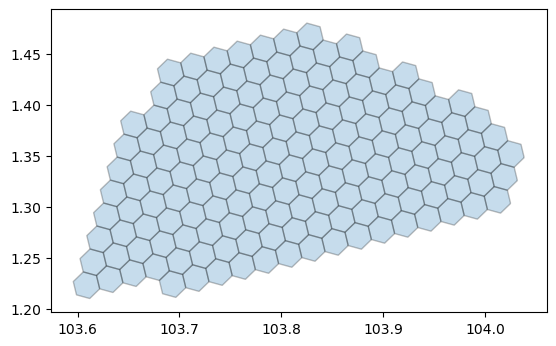

In [163]:
#hex_level = "5"
#hex_file = os.path.join(aux_dir, hex_base.format(hex_level))
hexagons = gdf # read_aoi_regions(hex_file)
base = hexagons.plot(alpha=.25, ec="k", zorder=1)

In [164]:
hexagons['h3_id']

0        0
1        1
2        2
3        3
4        4
      ... 
153    153
154    154
155    155
156    156
157    157
Name: h3_id, Length: 158, dtype: int64

#### Generate OD matrix template of regions

In [165]:
print(help(roi_od_template))

Help on function roi_od_template in module trakit.metrics.od_probability:

roi_od_template(region_id_series: pandas.core.series.Series | geopandas.geoseries.GeoSeries, freg: str = 'from_region', treg: str = 'to_region')
    Create the full AOI OD template for regions.
    
    Parameters
    ----------
    
    region_id_series : pandas.Series | geopandas.GeoSeries
        Region IDs.
    freg : str (default is 'from_region')
        From region name (index).
    treg : str (default is 'to_region')
        To region name (columns).
    
    Returns
    -------
    
    od_template : pandas.DataFrame
        full OD region template for AOI.

None


In [166]:
#matrix_template = roi_od_template(hexagons["hex_id"])
matrix_template = roi_od_template(hexagons["h3_id"])
matrix_template

to_region,0,1,2,3,4,5,6,7,8,9,...,148,149,150,151,152,153,154,155,156,157
from_region,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Calculate user-level OD counts

In [167]:
metric_label = "12"
_out_path = inter_metric_dir

In [168]:
global_start_time = time.time()

# diagnostic information
od_diagnostic = pandas.DataFrame(
    index=usp_dfs_processed.keys(),
    columns=["runtime_sec", "non_zero_regions"]
)

# user matrix container
od_mtxs = {}

for uid, usp in usp_dfs_processed.items():
    
    user_time_start = time.time()
    
    # calculate 1 user's OD counts
    usp_df = usp.copy()
    ttll_df = ttll_dfs[uid].copy()
    
    # generate region counts
    user_od_counts = trakit.region_od_matrix(
        usp_df,
        ttll_df,
        hexagons.copy(),
        matrix_template.copy(),
        region_id="h3_id",
        normalizer=None
    )
    
    # record diagnostic information
    n_non_zero = user_od_counts.astype(bool).sum().sum()
    user_time_end = round(time.time() - user_time_start, 2)
    od_diagnostic.loc[uid] = [user_time_end, n_non_zero]
    
    # store user's raw counts
    od_mtxs[uid] = user_od_counts
    
    # write user-level counts
    _out_file_base = metric_output_base.format(metric_label, uid)
    out_path = os.path.join(_out_path, f"{_out_file_base}.csv")
    user_od_counts.rename_axis(None).rename_axis(None, axis="columns").to_csv(out_path)

global_time_end = round(time.time() - global_start_time, 2)
print(f"Total Runtime (seconds): {global_time_end}")
od_diagnostic

Total Runtime (seconds): 0.15


,runtime_sec,non_zero_regions
part-00000-5551339c-daa2-46af-ad3d-05486818b52d,0.07,2
part-00000-1377f0cb-4454-4ccf-9d1c-5205488cfb3d,0.07,4


##### Demonstration plot for a single actor OD counts

In [169]:
print(help(trakit.od_score_plot))

Help on function od_score_plot in module trakit.metrics.od_probability:

od_score_plot(matrix: pandas.core.frame.DataFrame, diag_value: str = 'keep', figsize: tuple = (15, 15), sns_cmap: str = 'Blues', no_ticks: bool = True)
    Plot a heat map for OD probability.
    
    Parameters
    ----------
    
    matrix : pandas.DataFrame
        OD Probablity matrix
    diag_value : str, int, float (default 'keep')
        Set the matrix to this value before plotting.
        If ``'keep'`` (default) the true diagonal is kept.
    figsize : tuple (default (15,15))
        Figure size passed into matplotlib.
    sns_cmap : str (default 'Blues')
        Colormap for the heatmap. For more infor see:
        ``https://seaborn.pydata.org/tutorial/color_palettes.html``
    no_ticks : bool (default True)
        Plot the heatmap without x- or y-axis tick labels

None


part-00000-5551339c-daa2-46af-ad3d-05486818b52d


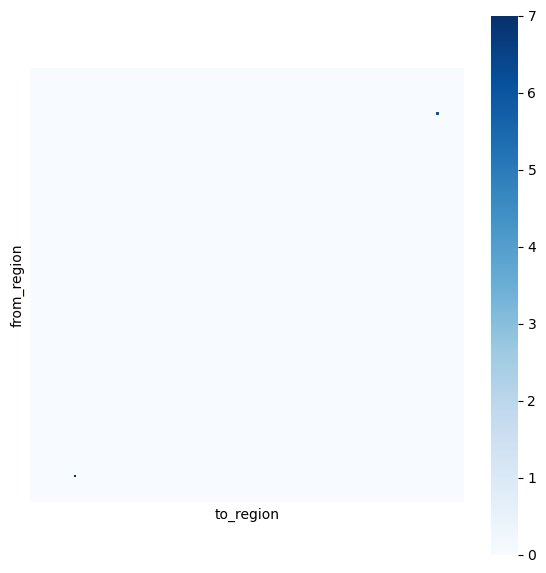

In [170]:
#actor = "77040a6e-bd01-41ea-b451-4d0c2c6d82e9"
actor = list(sp_dfs_processed.keys())[0]
print(actor)
trakit.od_score_plot(od_mtxs[actor].copy(), figsize=(7,7))

#### Aggregate user-level OD counts

In [171]:
_out_path = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")
outpath = os.path.join(_out_path, f"{_out_file_base}")
if outpath.endswith("_"):
    outpath = outpath[:-1]
outpath = f"{outpath}.csv"

In [172]:
aggregated_matrix = sum(od_mtxs.values())
aggregated_matrix.rename_axis(None).rename_axis(None, axis="columns").to_csv(outpath)
aggregated_matrix

to_region,0,1,2,3,4,5,6,7,8,9,...,148,149,150,151,152,153,154,155,156,157
from_region,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Demonstration plot for a aggregated actor OD counts

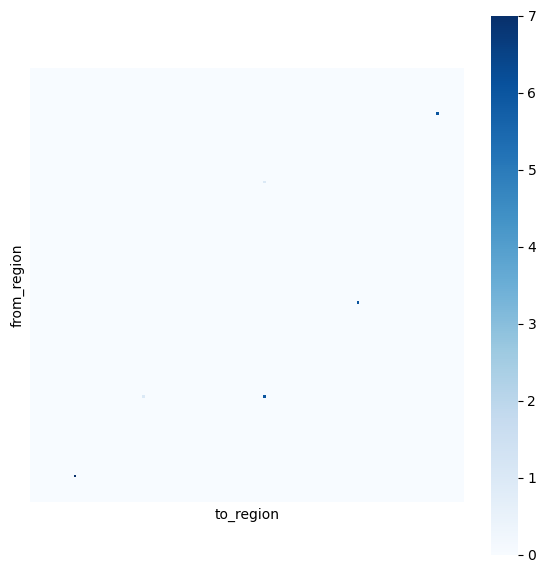

In [173]:
trakit.od_score_plot(aggregated_matrix, figsize=(7,7))

-------------------------------------------------------------

### 4.B.  M13 – Importance

In [174]:
from trakit.metrics import importance

In [175]:
metric_label = "13"
_out_path = agg_metric_dir
_out_file_base = metric_output_base.format(metric_label, "")

In [158]:
#hex_level = "5"
#hex_file = os.path.join(aux_dir, hex_base.format(hex_level))
#hexagons = read_aoi_regions(hex_file)

In [176]:
dfs = []

for ix, uid in enumerate(sp_dfs_processed.keys()):
    sp_df = sp_dfs_processed[uid].copy()
    dfs.append(sp_df)

sp_tot = pandas.concat(dfs)

stoppoint_df = geopandas.GeoDataFrame(
    sp_tot,
    geometry=geopandas.points_from_xy(sp_tot.longitude, sp_tot.latitude),
    crs=4326
)

combined_df = importance.join_dataframes(stoppoint_df, hexagons)

df = importance.stop_percentage(combined_df)

outpath = os.path.join(_out_path, f"{_out_file_base}")
if outpath.endswith("_"):
    outpath = outpath[:-1]
outpath = f"{outpath}.csv"
df.to_csv(outpath, index=False)

/home/local/KHQ/joseph.vanpelt/miniconda3/envs/py310_trakit/lib/python3.10/site-packages/geopandas/geodataframe.py:1581: UserWarning: Unable to sort modes: '<' not supported between instances of 'Point' and 'Point'
  result = super().apply(


In [177]:
df.reset_index(drop=True)

,index,h3_id,HOW,spid_percentage
0,0,16,11,14.285714
1,0,16,39,14.285714
2,0,16,57,14.285714
3,0,16,81,14.285714
4,0,16,108,14.285714
5,0,16,130,14.285714
6,0,16,153,14.285714
7,0,41,104,100.000000
8,0,85,10,14.285714
9,0,85,34,14.285714


-------------------------------------------------------------

### 4.C.  M14 – Connectivity

Relevant class:
* `trakit.Connnectivity`

In [178]:
from trakit import Connectivity
print(help(Connectivity))

Help on class Connectivity in module trakit.metrics.connectivity:

class Connectivity(builtins.object)
 |  Connectivity(user_id: str, ttll_df: pandas.core.frame.DataFrame, udf: pandas.core.frame.DataFrame, f: str = 'from', t: str = 'to', src: str = 'source', tgt: str = 'target', ycol: str = 'latitude', xcol: str = 'longitude', weight: None | str = None, silence_warnings: bool = True)
 |  
 |  HAYSTAC TraKit Connectivity object.
 |  
 |  Parameters
 |  ----------
 |  
 |  user_id : str
 |      User ID. This can be an arbitary string for synthetic data & testing.
 |  ttll_df : pandas.DataFrame
 |      Time Trips Linking Location data.
 |      See ``trakit.timed_trips_linking_locations`` for further details. This
 |      is added as an attribute and updated with local (individual node/edge)
 |      network statistic values.
 |  udf : pandas.DataFrame
 |      Unique stop locations.
 |  f : str (default is 'from')
 |      From node column name in ``ttll_df``.
 |  t : str (default is 'to')
 

In [179]:
print(help(Connectivity.ttll_to_networkx))

Help on function ttll_to_networkx in module trakit.metrics.connectivity:

ttll_to_networkx(self, remove_roundtrips: bool = False, uid_col: str = 'id', tinfo: str = 'trip_info', nx_kws: dict = {})
    Convert Time Trips Linking Locations to a NetworkX graph.
    
    Parameters
    ----------
    
    remove_roundtrips : bool (default False)
        Flag for removing round trip edges (e.g. from node 0 to node 0).
        IMPORTANT -- Removing roundtrips automatically resets the
        dataframe index if trips are squashed.
    uid_col : str (default 'id')
        Unique stop locations ID column name.
    tinfo : str (default 'trip_info')
        Column name from trip information in ``Connectivity.ttll_df``.
    nx_kws : dict (default dict())
        Search: networkx.convert_matrix.from_pandas_edgelist

None


In [180]:
print(help(Connectivity.calculate_all_stats))

Help on function calculate_all_stats in module trakit.metrics.connectivity:

calculate_all_stats(self, with_numpy=True, time_decimal=5, exclude=None)
    Calculate all available networks stats with default parameters.
    
    Parameters
    ----------
    
    with_numpy : bool (default True)
        Calculate measures with ``numpy`` (if available).
    time_decimal : int (default 5)
        Round timer to this many seconds.
    exclude : None | list (default None)
        Exclude these network measure from calculation.
    
    Returns
    -------
    
    None

None


##### Parameters:
* `weight`
  * Edge weight column name from TTLL; used for plotting.
* `remove_roundtrips` – 
  * Remove `'from'=='to'` node graph edges (see TTLL). Default is `False`.
* `nx_kws`
  * [`create_using`](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html#from-pandas-edgelist) (from NetworkX)
     * Type of NetworkX graph to create. Default is `networkx.Graph` (undirected). We will use `networkx.DiGraph` (directed).

In [217]:
weight = "n_trips"
remove_roundtrips = False
nx_kws = dict(create_using=networkx.DiGraph)
nx_kws

{'create_using': networkx.classes.digraph.DiGraph}

#### Generate `Connectivity` objects for each actor from:
* Timed Trips Linking Locations (TTLL)
* Level 2 Stop Locations – Unique Stop Points

In [213]:
metric_label = "14"
_out_path = inter_metric_dir

In [214]:
def adjust_global_connectivity_format(global_stats):
    """File format adjustment for deliverable. Consider adding to base later."""
    global_stats = global_stats.set_index("stat").T.reset_index(drop=True)
    global_stats.rename_axis(None, axis=1, inplace=True)
    global_cols = global_stats.columns.tolist()
    global_stats["coord_id"] = [-1]
    global_stats["node_id"] = [-1]
    global_stats = global_stats[["coord_id", "node_id"] + global_cols].copy()
    return global_stats

In [218]:
# calculate connectivity for each user
user_graphs = {}

for uid, usp in usp_dfs_processed.items():
    print(f"uid: {uid}, usp: \n{usp}")
    # calculate 1 user's Connectivity
    usp_df = usp.copy()
    ttll_df = ttll_dfs[uid].copy()
    
    conn_graph = Connectivity(
        uid, ttll_df, usp_df, weight=weight, silence_warnings=False
    )
    conn_graph.ttll_to_networkx(remove_roundtrips=remove_roundtrips, nx_kws=nx_kws)
    #conn_graph.calculate_all_stats()
    
    # write user-level global stats
    _out_file_base = metric_output_base.format(metric_label, "global")
    out_path = os.path.join(_out_path, f"{_out_file_base}_{uid}.csv")
    _global_stats = adjust_global_connectivity_format(conn_graph.global_stats)
    _global_stats.to_csv(out_path, index=False)
    
    # write user-level local stats
    _out_file_base = metric_output_base.format(metric_label, "local")
    out_path = os.path.join(_out_path, f"{_out_file_base}_{uid}.csv")
    conn_graph.local_stats.to_csv(out_path, index=False)
    
    # write user-level graph
    _out_file_base = metric_output_base.format(metric_label, "graph")
    out_path = os.path.join(_out_path, f"{_out_file_base}_{uid}.gml")
    networkx.write_gml(conn_graph.graph, out_path, stringizer=str)
    
    user_graphs[uid] = conn_graph

uid: part-00000-5551339c-daa2-46af-ad3d-05486818b52d, usp: 
   id  latitude  longitude   count              stop_points
0   0  1.309980  103.93102  286051  [0, 2, 4, 6, 8, 10, 12]
1   1  1.296516  103.86772  302543  [1, 3, 5, 7, 9, 11, 13]


AttributeError: 'Connectivity' object has no attribute 'global_stats'

##### Demostrating user-level stats
Global

In [209]:
#actor = "44ce589d-4288-4828-a624-30827a595588"
actor = list(sp_dfs_processed.keys())[0]

In [210]:
user_graphs[actor].global_stats

AttributeError: 'Connectivity' object has no attribute 'global_stats'

Local

In [219]:
user_graphs[actor].local_stats

KeyError: 'part-00000-5551339c-daa2-46af-ad3d-05486818b52d'

Calculation runtimes

In [220]:
user_graphs[actor].stat_runtimes

KeyError: 'part-00000-5551339c-daa2-46af-ad3d-05486818b52d'

##### Demostrating user-level plots

In [221]:
print(help(Connectivity.plot_graph))

Help on function plot_graph in module trakit.metrics.connectivity:

plot_graph(self, seed: None | int = 1, id_label: bool = False, add_labels: bool = False, draw_kws: dict = {}, plot_kws: dict = {})
    Helper plotter for sanity checks, demos, etc.
    
    Parameters
    ----------
    
    seed : {None, int}  (default is 1)
        If ``None`` the graph is plotted in a geographic layout. If an ``int``
        is passed in, the graph is plotted in ``networkx.spring_layout()``.
    id_label : bool (default is False)
        Set to ``True`` to give graph elements node-style labels.
        Otherwise, graph elements are given coordinate-style labels.
        IMPORTANT -- The ``add_labels`` keyword argument must also
        be set to ``True`` to utilize this functionality.
    add_labels : bool (default is False)
        Set to ``True`` to label graph elements.
    draw_kws : dict (default dict())
        Keyword argument for ``networkx.draw()``.
    plot_kws : dict (default dict())
    

Spring Layout

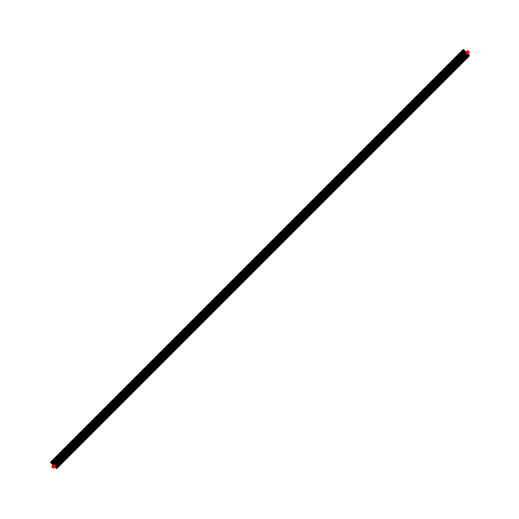

In [222]:
nxdraw_kws = dict(node_color="red", node_size=4, arrows=False)
mpl_kws = dict(figsize=(5, 5))
plt_kws = dict(draw_kws=nxdraw_kws, plot_kws=mpl_kws)
conn_graph.plot_graph(seed=1, id_label=False, add_labels=False, **plt_kws)

Geographic Layout

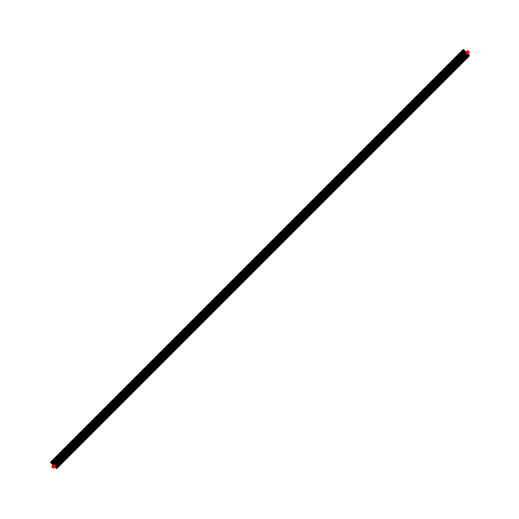

In [223]:
conn_graph.plot_graph(seed=0, id_label=False, add_labels=False, **plt_kws)

#### Generate a `Connectivity` object for ***all*** actors from:
* Set – Timed Trips Linking Locations (STTLL)
* Level 3 Stop Locations – Set Unique Stop Points

***Important***: Due to the actors disconnected activity patterns, `average_shortest_path_length` and `diameter` cannot be calculated.

In [224]:
_out_path = agg_metric_dir

In [225]:
# calculate aggregate user Connectivity
susp_df = set_unique_frame.copy()
sttll_df = sttll.copy()

conn_graph = Connectivity(
    "aggregate", sttll_df, susp_df, weight=weight, silence_warnings=False
)
conn_graph.ttll_to_networkx(remove_roundtrips=remove_roundtrips, nx_kws=nx_kws)
conn_graph.calculate_all_stats(
    exclude=["average_shortest_path_length", "diameter"]
)

# write user-level global stats
_out_file_base = metric_output_base.format(metric_label, "global")
out_path = os.path.join(_out_path, f"{_out_file_base}.csv")
_global_stats = adjust_global_connectivity_format(conn_graph.global_stats)
_global_stats.to_csv(out_path, index=False)

# write user-level local stats
_out_file_base = metric_output_base.format(metric_label, "local")
out_path = os.path.join(_out_path, f"{_out_file_base}.csv")
conn_graph.local_stats.to_csv(out_path, index=False)

# write user-level graph
_out_file_base = metric_output_base.format(metric_label, "graph")
out_path = os.path.join(_out_path, f"{_out_file_base}.gml")
networkx.write_gml(conn_graph.graph, out_path, stringizer=str)

##### Demostrating aggregate-level stats
Global

In [226]:
conn_graph.global_stats

,stat,value
0,average_shortest_path_length,NaN
1,density,0.3
2,diameter,NaN


Local

In [227]:
conn_graph.local_stats

,coord_id,node_id,betweenness_centrality,closeness_centrality,degree_centrality,eigenvector_centrality_numpy,katz_centrality_numpy,pagerank
0,"(1.3099798203125468, 103.93101951785043)",0,0.000000,0.250000,0.50,0.000000e+00,0.437069,0.200000
1,"(1.2965162595399569, 103.86771963794527)",1,0.000000,0.250000,0.50,2.220446e-16,0.437069,0.200000
2,"(1.388837264405529, 103.989854044995)",2,0.083333,0.333333,0.75,5.484318e-01,0.441488,0.232675
3,"(1.2661929852129403, 103.614604284031)",3,0.083333,0.500000,0.75,7.265174e-01,0.481262,0.238440
4,"(1.3463496983805563, 103.64985617003838)",4,0.000000,0.333333,0.50,4.139989e-01,0.437511,0.128886


Calculation runtimes

In [228]:
conn_graph.stat_runtimes

,stat,seconds
0,average_shortest_path_length,0.00052
1,betweenness_centrality,0.00734
2,closeness_centrality,0.00334
3,degree_centrality,0.00288
4,density,0.00085
5,diameter,0.00077
6,eigenvector_centrality_numpy,0.00425
7,katz_centrality_numpy,0.00318
8,pagerank,0.00622


##### Demostrating aggregate-level plots

Spring Layout

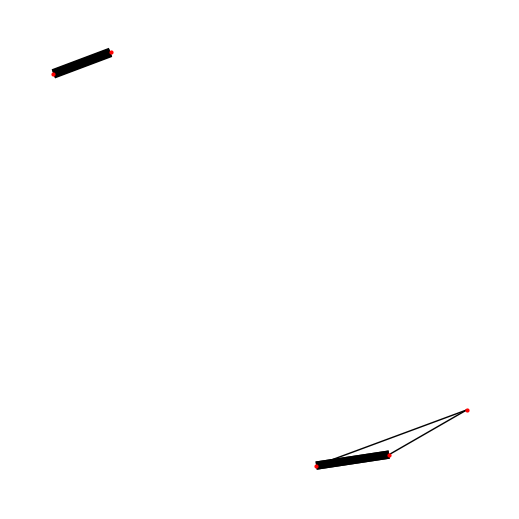

In [229]:
conn_graph.plot_graph(seed=1, id_label=False, add_labels=False, **plt_kws)

Geographic Layout

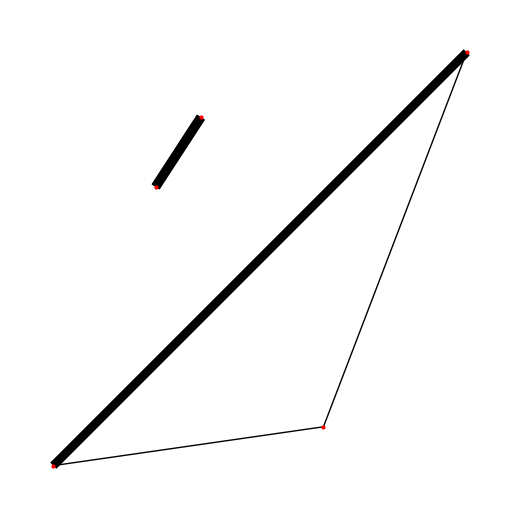

In [230]:
conn_graph.plot_graph(seed=0, id_label=False, add_labels=False, **plt_kws)

-------------------------------------------------------------